In [62]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [63]:
from torchvision import models, transforms
from torchvision.models import VGG16_Weights
from torchvision.datasets import ImageFolder

In [64]:
import matplotlib.pyplot as plt
from PIL import Image

In [65]:
vgg16_model = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1)

for param in vgg16_model.parameters():
    param.requires_grad = False

num_classes = 10
vgg16_model.classifier[6] = nn.Linear(vgg16_model.classifier[6].in_features, num_classes)

criterion = nn.CrossEntropyLoss()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16_model.to(device)

learning_rate = 0.001
optimizer = optim.Adam(vgg16_model.classifier[6].parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

print(vgg16_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [66]:
def calculate_accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    correct = (preds == labels).sum().item()
    total = labels.size(0)
    accuracy = correct / total
    return accuracy

In [67]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = ImageFolder(root='drive/MyDrive/inputs/train/', transform=train_transforms)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)

In [68]:
train_losses = []
train_accuracy = []

num_epochs = 32
for epoch in range(num_epochs):

    vgg16_model.train()

    running_loss = 0.0
    running_accuracy = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = vgg16_model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()

        accuracy = calculate_accuracy(outputs, labels)

        running_loss += loss.item()
        running_accuracy += accuracy

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = running_accuracy / len(train_loader)

    train_losses.append(loss)
    train_accuracy.append(accuracy)

    print(f'Epoch {epoch+1}: [ Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f} ]')

Epoch 1: [ Loss: 1.0757, Accuracy: 0.6297 ]
Epoch 2: [ Loss: 0.7258, Accuracy: 0.7394 ]
Epoch 3: [ Loss: 0.6334, Accuracy: 0.7751 ]
Epoch 4: [ Loss: 0.5775, Accuracy: 0.7951 ]
Epoch 5: [ Loss: 0.5643, Accuracy: 0.7991 ]
Epoch 6: [ Loss: 0.5391, Accuracy: 0.8158 ]
Epoch 7: [ Loss: 0.5082, Accuracy: 0.8167 ]
Epoch 8: [ Loss: 0.4860, Accuracy: 0.8212 ]
Epoch 9: [ Loss: 0.4760, Accuracy: 0.8333 ]
Epoch 10: [ Loss: 0.4533, Accuracy: 0.8416 ]
Epoch 11: [ Loss: 0.4474, Accuracy: 0.8397 ]
Epoch 12: [ Loss: 0.4239, Accuracy: 0.8450 ]
Epoch 13: [ Loss: 0.4189, Accuracy: 0.8467 ]
Epoch 14: [ Loss: 0.4225, Accuracy: 0.8453 ]
Epoch 15: [ Loss: 0.4429, Accuracy: 0.8497 ]
Epoch 16: [ Loss: 0.4279, Accuracy: 0.8448 ]
Epoch 17: [ Loss: 0.4062, Accuracy: 0.8547 ]
Epoch 18: [ Loss: 0.4032, Accuracy: 0.8562 ]
Epoch 19: [ Loss: 0.4162, Accuracy: 0.8539 ]
Epoch 20: [ Loss: 0.4339, Accuracy: 0.8420 ]
Epoch 21: [ Loss: 0.3589, Accuracy: 0.8661 ]
Epoch 22: [ Loss: 0.3773, Accuracy: 0.8641 ]
Epoch 23: [ Loss: 0

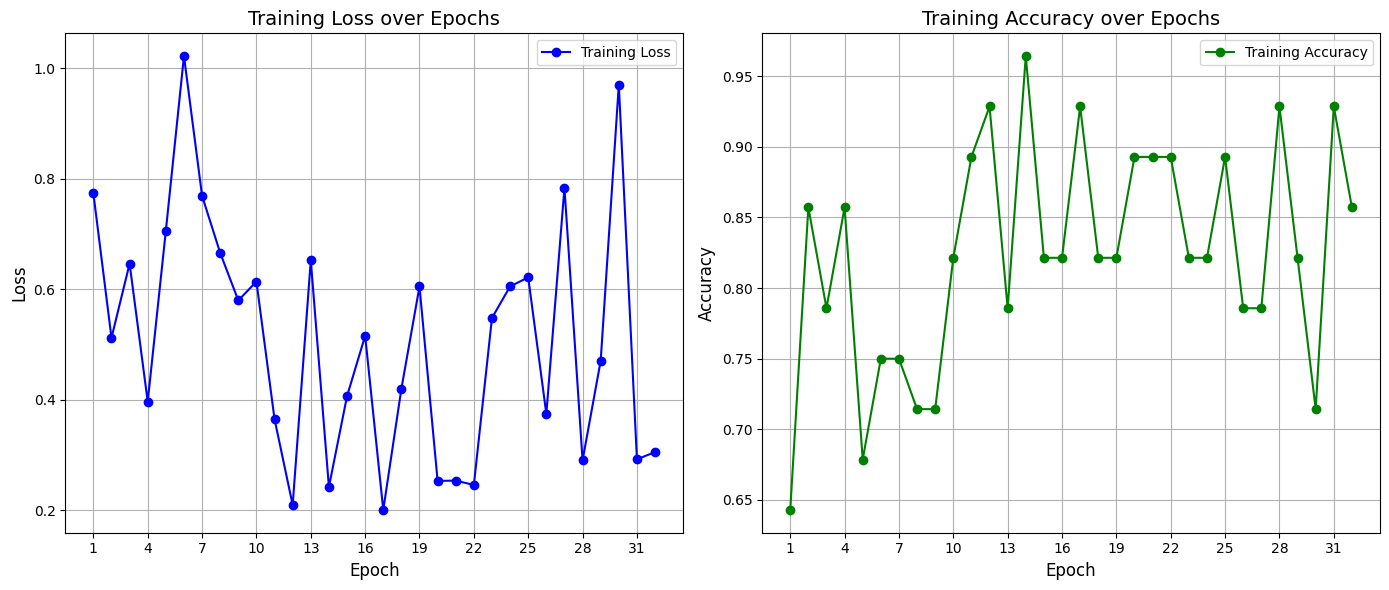

Epoch  Loss       Accuracy  
------------------------------
1      0.7735     0.6429    
2      0.5116     0.8571    
3      0.6460     0.7857    
4      0.3962     0.8571    
5      0.7054     0.6786    
6      1.0217     0.7500    
7      0.7687     0.7500    
8      0.6654     0.7143    
9      0.5794     0.7143    
10     0.6136     0.8214    
11     0.3644     0.8929    
12     0.2092     0.9286    
13     0.6520     0.7857    
14     0.2418     0.9643    
15     0.4061     0.8214    
16     0.5155     0.8214    
17     0.2001     0.9286    
18     0.4195     0.8214    
19     0.6047     0.8214    
20     0.2528     0.8929    
21     0.2533     0.8929    
22     0.2455     0.8929    
23     0.5477     0.8214    
24     0.6048     0.8214    
25     0.6211     0.8929    
26     0.3740     0.7857    
27     0.7833     0.7857    
28     0.2899     0.9286    
29     0.4702     0.8214    
30     0.9698     0.7143    
31     0.2919     0.9286    
32     0.3050     0.8571    


In [82]:
# Convert tensor values to floats for plotting
train_losses = [loss.cpu().item() if isinstance(loss, torch.Tensor) else loss for loss in train_losses]
train_accuracy = [acc.cpu().item() if isinstance(acc, torch.Tensor) else acc for acc in train_accuracy]

# Plotting function
def plot_training_metrics(train_losses, train_accuracy, num_epochs):
    plt.figure(figsize=(14, 6))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, marker='o', color='b', linestyle='-', label='Training Loss')
    plt.title('Training Loss over Epochs', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.xticks(range(1, num_epochs + 1, max(1, num_epochs // 10)))  # Adjust for better tick marks
    plt.grid(True)
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracy, marker='o', color='g', linestyle='-', label='Training Accuracy')
    plt.title('Training Accuracy over Epochs', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.xticks(range(1, num_epochs + 1, max(1, num_epochs // 10)))
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

# Display loss and accuracy for each epoch
def display_epoch_metrics(train_losses, train_accuracy):
    print(f"{'Epoch':<6} {'Loss':<10} {'Accuracy':<10}")
    print('-' * 30)
    for epoch in range(len(train_losses)):
        print(f"{epoch + 1:<6} {train_losses[epoch]:<10.4f} {train_accuracy[epoch]:<10.4f}")

# Plot the metrics
plot_training_metrics(train_losses, train_accuracy, num_epochs)

# Print the metrics in tabular form
display_epoch_metrics(train_losses, train_accuracy)

In [72]:
def get_clothing_item(number):
    clothing_items = {
        0: 'dress',
        1: 'hat',
        2: 'longsleeve',
        3: 'outwear',
        4: 'pants',
        5: 'shirt',
        6: 'shoes',
        7: 'shorts',
        8: 'skirt',
        9: 't-shirt'
    }

    return clothing_items.get(number, 'Unknown')

Predicted class: shoes


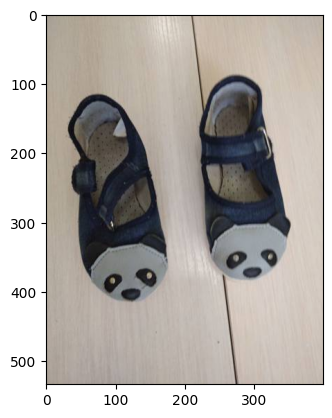

In [76]:
def predict_image(model, image_path, transform, device):
    model.eval()

    image = Image.open(image_path).convert('RGB')
    plt.imshow(image)
    image = transform(image)
    image = image.unsqueeze(0)

    image = image.to(device)

    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)

    return predicted.item()

# Predict the class of a new image
image_path = 'drive/MyDrive/inputs/test/shoes/07d88b75-85a4-407b-aa73-12294a2ff9a8.jpg'


predicted_class_index = predict_image(vgg16_model, image_path, train_transforms, device)
print(f'Predicted class: {get_clothing_item(predicted_class_index)}')

In [78]:
test_dataset = ImageFolder(root='drive/MyDrive/inputs/test', transform=train_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Function to evaluate the model on the test set
def evaluate_model(model, test_loader):

    model.eval()  # Set model to evaluation mode

    test_loss = 0.0
    test_accuracy = 0.0

    criterion = nn.CrossEntropyLoss()  # Reuse the same loss function

    with torch.no_grad():  # No gradients needed during testing
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            accuracy = calculate_accuracy(outputs, labels)
            test_loss += loss.item()
            test_accuracy += accuracy

    # Calculate average loss and accuracy
    test_loss /= len(test_loader)
    test_accuracy /= len(test_loader)

    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

# Call the evaluate function after training is done
evaluate_model(vgg16_model, test_loader)

Test Loss: 0.5679, Test Accuracy: 0.8010
